In [1]:
import os
import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset
import pyexr

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle, RaySamples, Frustums
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
from nerfstudio.viewer.server import viewer_utils
import tinycudann as tcnn

from reni_neus.models.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import look_at_target, random_points_on_unit_sphere
from reni_neus.data.datamanagers.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.configs.ddf_config import DirectionalDistanceField
from reni_neus.configs.reni_neus_config import RENINeuS
from reni_neus.utils.utils import find_nerfstudio_project_root, rot_z

from reni.illumination_fields.environment_map_field import EnvironmentMapFieldConfig

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

# setup config
test_mode = 'test'
world_size = 1
local_rank = 0
device = 'cuda:0'

scene = 'site2'

reni_neus_config = RENINeuS
reni_neus_config.config.load_dir = Path(f'/workspace/reni_neus/models/{scene}/nerfstudio_models')
reni_neus_config.config.load_step = 100000
reni_neus_config.config.pipeline.datamanager.dataparser.scene = scene

if scene == 'site1':
    reni_neus_config.config.pipeline.datamanager.dataparser.session_holdout_indices=[0, 0, 0, 0, 0]
elif scene == 'site2':
    reni_neus_config.config.pipeline.datamanager.dataparser.session_holdout_indices=[2, 14, 2, 7, 9]
elif scene == 'site3':
    reni_neus_config.config.pipeline.datamanager.dataparser.session_holdout_indices=[0, 6, 6, 2, 11]

trainer = reni_neus_config.config.setup(local_rank=local_rank, world_size=world_size)
trainer.setup(test_mode=test_mode)
pipeline = trainer.pipeline
datamanager = pipeline.datamanager
model = pipeline.model
model = model.eval()

[08:19:18] Saving checkpoints to: outputs/reni-neus/reni-neus/{timestamp}/nerfstudio_models               ]8;id=25921;file:///workspace/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=799984;file:///workspace/nerfstudio/engine/trainer.py#134\134]8;;\

Setting up training dataset...

Caching all 258 images.

Output()

Setting up evaluation dataset...

Caching all 96 images.

Output()

Caching all 96 images.

Output()

╭─────────────────────────────────────────── Viewer ───────────────────────────────────────────╮
│        ╷                                                                                     │
│   HTTP │ ]8;id=342054;https://viewer.nerf.studio/versions/23-05-15-1/?websocket_url=ws://localhost:7007\https://viewer.nerf.studio/versions/23-05-15-1/?websocket_url=ws://localhost:7007]8;;\   │
│        ╵                                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────╯

[NOTE] Not running eval iterations since only viewer is enabled.
Use --vis {wandb, tensorboard, viewer+wandb, viewer+tensorboard} to run with eval.

Done loading Nerfstudio checkpoint from /workspace/reni_neus/models/site3/nerfstudio_models/step-000100000.ckpt

Disabled comet/tensorboard/wandb event writers

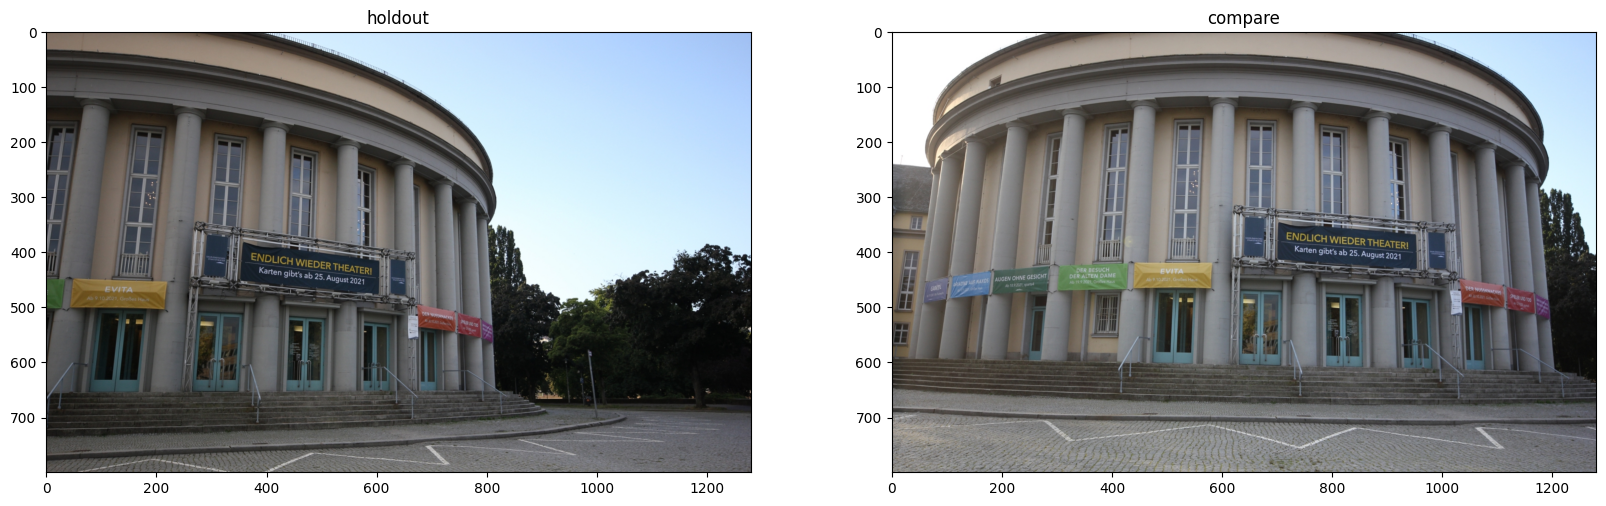

In [6]:
# Test Set Data
idx = 4
holdout_indices = datamanager.eval_session_holdout_dataloader.selected_indices
compare_indices = datamanager.eval_session_compare_dataloader.selected_indices
image_batch_holdout = datamanager.eval_dataset[holdout_indices[idx]]
image_batch_compare = datamanager.eval_dataset[compare_indices[idx]]
# plot both batch['image'] side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image_batch_holdout['image'].cpu().numpy())
axs[0].set_title('holdout')
axs[1].imshow(image_batch_compare['image'].cpu().numpy())
axs[1].set_title('compare')
plt.show()

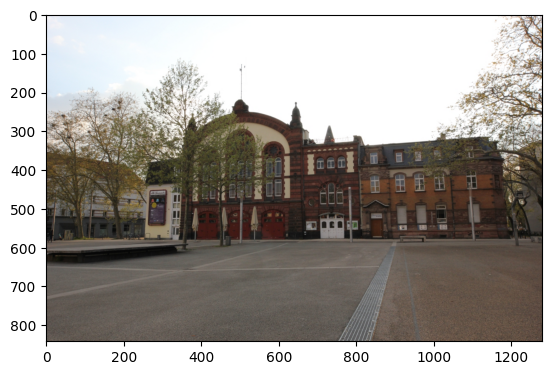

In [2]:
# Viewing Ground Truth Data
i = i + 1
image_batch = datamanager.train_image_dataloader[i]
plt.imshow(image_batch['image'].cpu().numpy())

In [65]:
# Site 1: Train: 143
# Site 3: Train: 63 (Bright, Front, Blue Sky), 90 (Sun Behind Building, Shadow of Building on Ground)
idx = 53
image_batch = datamanager.train_image_dataloader[idx]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx
ray_bundle = ray_bundle.to(device)
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
model.viewing_training_image = False
rgb = model_output['rgb'].cpu().numpy()

Output()

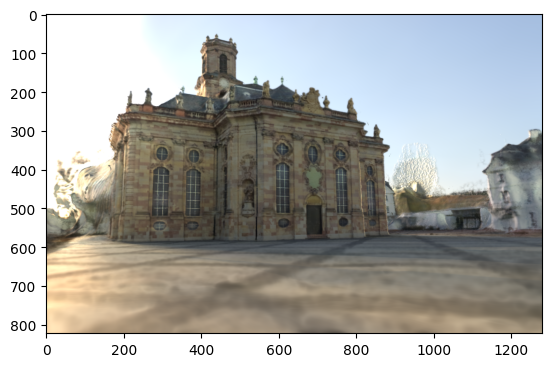

In [66]:
plt.imshow(rgb)

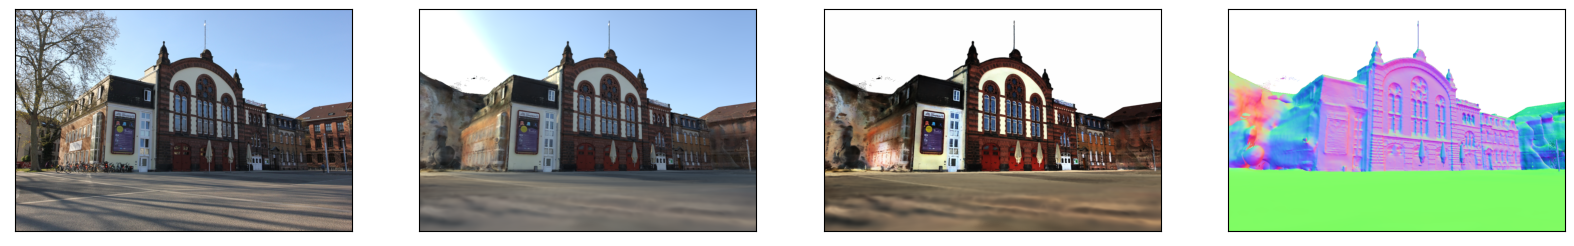

In [5]:
camera_to_world = datamanager.train_dataset.cameras.camera_to_worlds[idx]
gt_image = image_batch['image'].cpu().numpy()
rgb = model_output['rgb'].cpu().numpy()
albedo = model_output['albedo'].cpu().numpy()
normal = model_output['normal'].cpu()
normal = normal @ camera_to_world[:3, :3]
normal_scaled = (normal + 1) / 2
normal_scaled[normal.norm(dim=-1) < 0.5] = 1
normal_scaled = normal_scaled.numpy()

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(gt_image)
axs[1].imshow(rgb)
axs[2].imshow(albedo)
axs[3].imshow(normal_scaled)
# remove all ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
# save figure as png
fig.savefig(f'/workspace/reni_neus/publication/{scene}_train_{idx}.png')

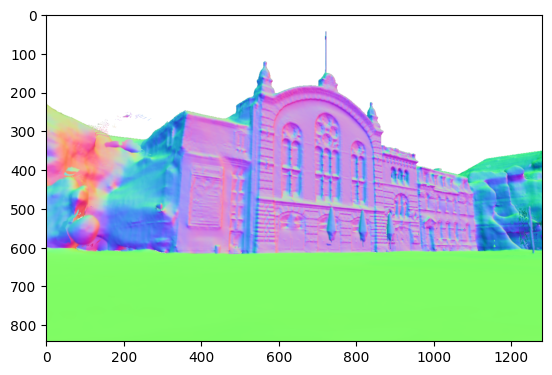

In [110]:
camera_to_world = datamanager.train_dataset.cameras.camera_to_worlds[90]
# convert normals which are in worls space into camera space
normal = model_output['normal'].cpu()
normal = normal @ camera_to_world[:3, :3]
normal_scaled = (normal + 1) / 2
normal_scaled[normal.norm(dim=-1) < 0.5] = 1
normal_scaled = normal_scaled.numpy()
plt.imshow(normal_scaled)

In [2]:
# Teaser Figure # Main center model
idx = 143
image_batch = datamanager.train_image_dataloader[idx]
camera = datamanager.train_dataset.cameras[idx]

# c2w = torch.Tensor([[0.8686691092636059, -0.07827432617684604, 0.48916981557812267, 0.8111372967256216],
#                   [0.4953927518758968, 0.13725370211973428, -0.8577572166080876, -1.42232584221105],
#                   [2.7755575615628914e-17, 0.9874383783892482, 0.15800458500946118, 0.26200188129629143]])

c2w = torch.Tensor([[0.8140520842810857, -0.1143569886002469, 0.5694222363377667, 0.8358360570182454],
                    [0.5807918767317777, 0.16028554918155577, -0.7981161185228294, -1.2939682630710383],
                    [-6.938893903907227e-17, 0.9804238990772565, 0.19689839541791582, 0.3899372857935357]])

x_min = -0.7
y_min = -0.5
z_min = -0.05
x_max = 0.4
y_max = 0.5
z_max = 1.0
crop_min = (x_min, y_min, z_min)
crop_max = (x_max, y_max, z_max)

viewer_utils.update_render_aabb(
    crop_viewport=True,
    crop_min=crop_min,
    crop_max=crop_max,
    model=model
)

camera.camera_to_worlds = c2w.type_as(camera.camera_to_worlds)
ray_bundle = camera.generate_rays(camera_indices=0, aabb_box=model.render_aabb)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx
ray_bundle = ray_bundle.to(device)
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
model.viewing_training_image = False

# use model_output['accumulation'] to mask ['rgb']
rgb = model_output['rgb'].cpu().numpy()
accumulation = model_output['accumulation'].cpu().numpy()
rgb = rgb * accumulation + (1 - accumulation)
# export rgb as png
plt.imsave('/workspace/reni_neus/publication/teaser_center.png', rgb)
plt.imshow(rgb)

Output()

In [29]:
# teaser figure albedo and normals
idx = 11
image_batch = datamanager.train_image_dataloader[idx]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle = ray_bundle.to(device)
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
model.viewing_training_image = False
# save albedo and normal
camera_to_world = datamanager.train_dataset.cameras.camera_to_worlds[idx]
# convert normals which are in worls space into camera space
normal = model_output['normal'].cpu()
normal = normal @ camera_to_world[:3, :3]
normal_scaled = (normal + 1) / 2
normal_scaled[normal.norm(dim=-1) < 0.5] = 1
normal_scaled = normal_scaled.numpy()
albedo = model_output['albedo'].cpu().numpy()
plt.imsave('/workspace/reni_neus/publication/teaser_albedo.png', albedo)
plt.imsave('/workspace/reni_neus/publication/teaser_normal.png', normal_scaled)

Output()

In [77]:
idx = 143
image_batch = datamanager.train_image_dataloader[idx]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=27, keep_shape=True)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx
ray_bundle = ray_bundle.to(device)
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
model.viewing_training_image = False
rgb = model_output['rgb'].cpu().numpy()
plt.imsave('/workspace/reni_neus/publication/novel_view.png', rgb)

Output()

In [67]:
image_batch = datamanager.train_image_dataloader[11]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * 53
ray_bundle = ray_bundle.to(device)
model.viewing_training_image = True
rotation = None
# rotation = rot_z(torch.deg2rad(torch.tensor(90.0)))
# rotation = rotation.to(device)
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, rotation=rotation, show_progress=True)
model.viewing_training_image = False
rgb = model_output['rgb'].cpu().numpy()
plt.imsave('/workspace/reni_neus/publication/novel_illumination.png', rgb)

Output()

In [ ]:
# To compare against NeRF-OSR and FGER
image_batch = datamanager.train_image_dataloader[81]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * image_batch['image_idx']
ray_bundle = ray_bundle.to(device)
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
model.viewing_training_image = False
camera_to_world = datamanager.train_dataset.cameras.camera_to_worlds[image_batch['image_idx']]
rgb = model_output['rgb'].cpu().numpy()
normal = model_output['normal'].cpu()
normal = normal @ camera_to_world[:3, :3]
normal_scaled = (normal + 1) / 2
normal_scaled[normal.norm(dim=-1) < 0.5] = 1
normal_scaled = normal_scaled.numpy()
albedo = model_output['albedo'].cpu().numpy()
# crop W between 309, 1003 and H between 0 and 523
rgb = rgb[:523, 307:1001, :]
albedo = albedo[:523, 307:1001, :]
normal_scaled = normal_scaled[:523, 307:1001, :]

plt.imsave('/workspace/reni_neus/publication/comparison_full.png', rgb)
plt.imsave('/workspace/reni_neus/publication/comparison_albedo.png', albedo)
plt.imsave('/workspace/reni_neus/publication/comparison_normal.png', normal_scaled)

In [35]:
image_batch = datamanager.train_image_dataloader[81]
plt.imshow('')

In [45]:
nerf_osr_normals_path = '/workspace/reni_neus/publication/nerfosr_normals.png'
fegr_normals_path = '/workspace/reni_neus/publication/fegr_normals.png'

# load them into numpy arrays
nerf_osr_normals = plt.imread(nerf_osr_normals_path)
fegr_normals = plt.imread(fegr_normals_path)

nerf_osr_normals = nerf_osr_normals[15:928, 41:1218, :]
fegr_normals = fegr_normals[:913, 40:1217, :]

# Assuming the image is in the standard 8-bit per channel format
tolerance = 0  # You can adjust this based on how strict you want to be about the color white
white_mask = np.all(nerf_osr_normals >= (1 - tolerance), axis=-1)
# Invert the mask to identify non-white pixels
non_white_mask = ~white_mask
# Apply the transformation only to non-white pixels
nerf_osr_normals[non_white_mask, 0] = 1 - nerf_osr_normals[non_white_mask, 0]

white_mask = np.all(fegr_normals >= (1 - tolerance), axis=-1)
# Invert the mask to identify non-white pixels
non_white_mask = ~white_mask
# Apply the transformation only to non-white pixels
fegr_normals[non_white_mask, 0] = 1 - fegr_normals[non_white_mask, 0]

plt.imsave('/workspace/reni_neus/publication/nerfosr_normals_fixed.png', nerf_osr_normals)
plt.imsave('/workspace/reni_neus/publication/fegr_normals_fixed.png', fegr_normals)

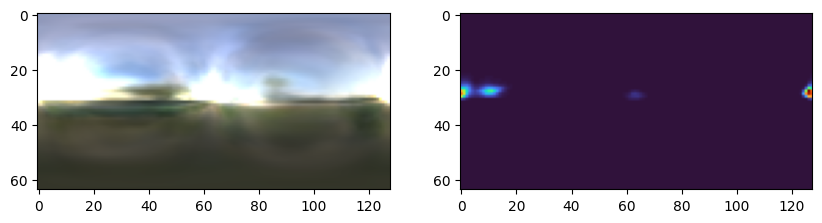

In [68]:
# teaser figure lighting 
from reni.field_components.field_heads import RENIFieldHeadNames
from nerfstudio.utils import colormaps
from reni.utils.colourspace import linear_to_sRGB

model.viewing_training_image = True
with torch.no_grad():
    illumination_latents, scales = model.get_illumination_field()
    ray_samples = model.equirectangular_sampler.generate_direction_samples()
    ray_samples = ray_samples.to(model.device)
    ray_samples.camera_indices = torch.ones_like(ray_samples.camera_indices) * 53
    illumination_field_outputs = model.illumination_field(ray_samples=ray_samples,
                                                          latent_codes=illumination_latents[ray_samples.camera_indices[:, 0]],
                                                          scale=scales[ray_samples.camera_indices[:, 0]],
    )

    hdr_envmap = illumination_field_outputs[RENIFieldHeadNames.RGB]
    hdr_envmap = model.illumination_field.unnormalise(hdr_envmap)  # N, 3
    ldr_envmap = linear_to_sRGB(hdr_envmap)  # N, 3
    # reshape to H, W, 3
    height = model.equirectangular_sampler.height
    width = model.equirectangular_sampler.width
    ldr_envmap = ldr_envmap.reshape(height, width, 3)

    hdr_mean = torch.mean(hdr_envmap, dim=-1)
    hdr_mean = hdr_mean.reshape(height, width, 1)
    hdr_mean_log_heatmap = colormaps.apply_depth_colormap(
        hdr_mean,
        near_plane=hdr_mean.min(),
        far_plane=hdr_mean.max(),
    )
model.viewing_training_image = False
# show hdr_mean_log_heatmap and ldr_envmap in one figure
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(ldr_envmap.cpu().detach().numpy())
ax2 = fig.add_subplot(122)
ax2.imshow(hdr_mean_log_heatmap.cpu().detach().numpy())
plt.show()

plt.imsave('/workspace/reni_neus/publication/teaser_envmap.png', ldr_envmap.cpu().detach().numpy())
plt.imsave('/workspace/reni_neus/publication/teaser_envmap_heatmap.png', hdr_mean_log_heatmap.cpu().detach().numpy())

### Relighting Under Environment Map

In [2]:
# get envmap if not downloaded 
envmap_path = Path('/workspace/reni_neus/publication/dam_wall_1k.exr')
envmap_url = 'https://dl.polyhaven.org/file/ph-assets/HDRIs/exr/1k/dam_wall_1k.exr'

if not envmap_path.exists():
    os.system(f'wget {envmap_url} -P {envmap_path.parent}')

envmap = pyexr.open(str(envmap_path))
envmap = torch.from_numpy(envmap.get('default'))
H, W = envmap.shape[:2]

In [3]:
environment_map_field_config = EnvironmentMapFieldConfig(path=envmap_path, resolution=(H, W), trainable=False, apply_padding=True, fixed_decoder=False)
envmap_field = environment_map_field_config.setup(num_train_data=1, num_eval_data=1, normalisations={})

In [150]:
i = 80

In [ ]:
# good idx's:
# site1
# train - 144 for shadows

81


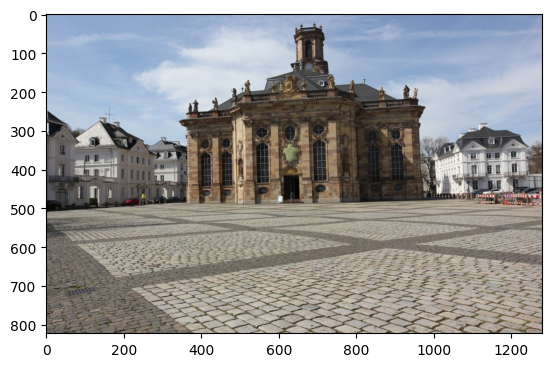

In [151]:
i = i + 1
print(i)
image_batch = datamanager.train_image_dataloader[i]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle = ray_bundle.to(device)
plt.imshow(image_batch['image'].cpu().numpy())

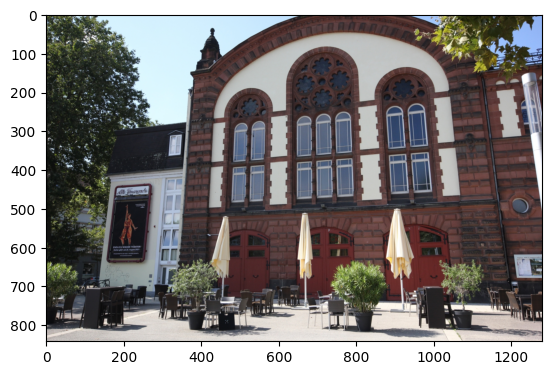

In [3]:

image_batch = datamanager.eval_dataset[2]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle = ray_bundle.to(device)
plt.imshow(image_batch['image'].cpu().numpy())

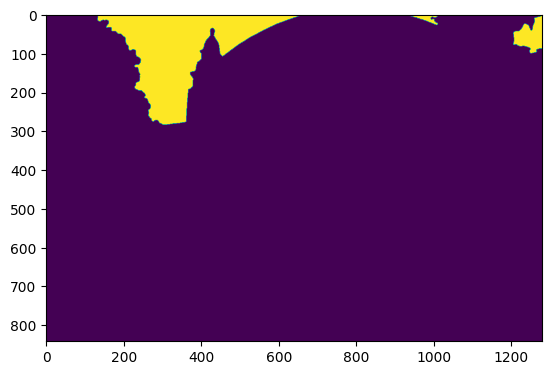

In [11]:
sampling_mask = image_batch['mask'][:, :, 3]
plt.imshow(sampling_mask.cpu().numpy())

In [192]:
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
metrics_dict, images_dict = model.get_image_metrics_and_images(model_output, image_batch)
model.viewing_training_image = False

Output()

/home/user/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning:

Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


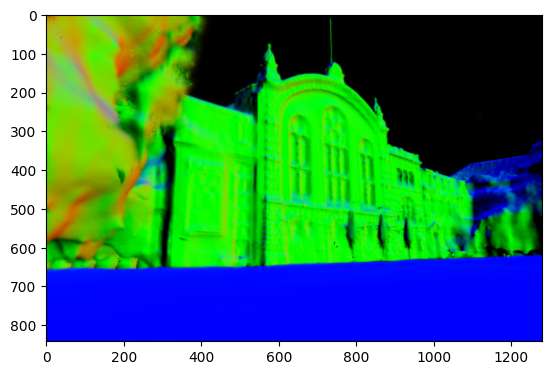

In [196]:
image = model_output['normal']
plt.imshow(image.cpu().numpy())

In [195]:
# compute psnr between image and gt
gt_image = image_batch['image']
mse = torch.mean((image - gt_image.type_as(image))**2)
psnr = -10*torch.log10(mse)
print(psnr)

@misc{charlmersgit2022,
  author = {charlmersgit},
  title = {SphericalHarmonics},
  year = {2022},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/chalmersgit/SphericalHarmonics}},
  commit = {cee7e6ea6bcf385202587ebeea0ee42d482ba295}
}

tensor(19.3024, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


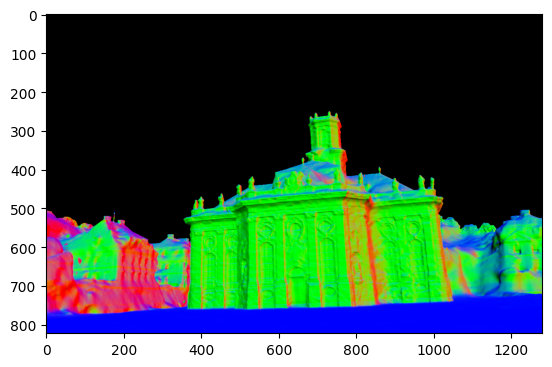

In [67]:
normals = model_output["field_normals"]
weights = model_output["weights"]
normals = normals.reshape(normals.shape[0], normals.shape[1], weights.shape[-1], 3)
normals = torch.sum(model_output["weights"].unsqueeze(-1) * normals, dim=-2)
normals = normals / normals.norm(dim=-1, keepdim=True)
normals[0, 0, :].norm()
normals[:, :, 1] = -normals[:, :, 1]

sky_mask = image_batch['mask'][:, :, 3:4].bool()
fg_mask = ~sky_mask
fg_mask = fg_mask.type_as(normals)
normals = normals * fg_mask
# # plot with different colour pallete
plt.imshow(normals.cpu().numpy())

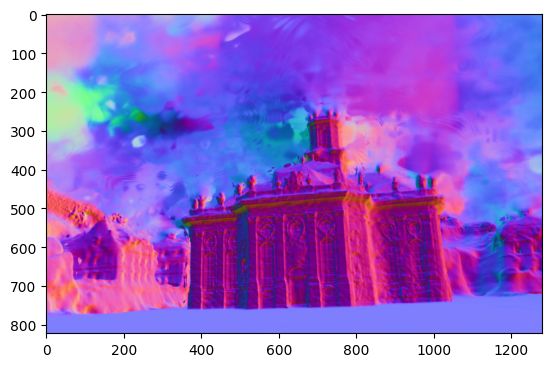

In [53]:
normals = images_dict['normal']
plt.imshow(images_dict['normal'].cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


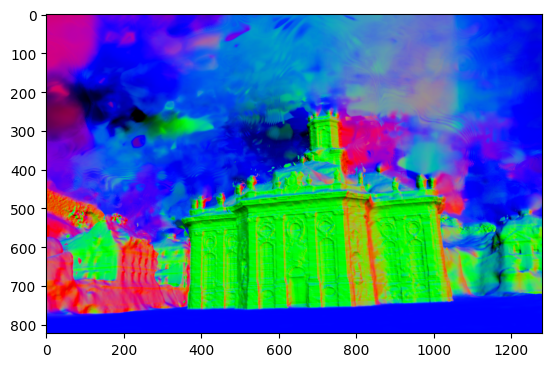

In [71]:
normals = model_output["field_normals"]
normals = normals.reshape(normals.shape[0], normals.shape[1], weights.shape[-1], 3)
normals = model.renderer_normal(normals=normals, weights=model_output["weights"].unsqueeze(-1), normalize=True)
# flip y axis
normals[:, :, 1] = -normals[:, :, 1]
plt.imshow(normals.cpu().numpy())



In [1]:
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nerfstudio.cameras.rays import Frustums
from nerfstudio.field_components.spatial_distortions import SceneContraction
import nerfstudio.utils.plotly_utils as vis

# Constants
num_rays = 2
num_samples = 1000
pixel_area = 0.12
far = 100  # Adjusting the far value to 2 as we are only interested in positions with a norm less than 2

# Generate ray origins and directions
origins = torch.Tensor([[0.0, 0.0, 0.4], [0.0, 0.2, -0.4]]).unsqueeze(1)
directions = torch.tensor([[0, 1, 0]]).unsqueeze(0).repeat(2, 1, 1).float()
directions = directions / directions.norm(dim=-1, keepdim=True)
bins = torch.linspace(0.1, 2, num_samples + 1)[None, ..., None]

# Create frustums
frustums_one = Frustums(
    origins=origins, directions=directions, starts=bins[:, :-1, :], ends=bins[:, 1:, :], pixel_area=pixel_area
)

# Create custom bins for sampling: Linear from 0 to 1, and quadratic from 1 to 2
linear_bins = torch.linspace(0, 1, num_samples // 2 + 1)
quadratic_bins = 1 + (torch.linspace(0, far, num_samples // 2 + 1) ** 2)
bins = torch.cat((linear_bins, quadratic_bins[1:]), dim=0)[None, ..., None]

# Create frustums
frustums_two = Frustums(
    origins=origins, directions=directions, starts=bins[:, :-1, :], ends=bins[:, 1:, :], pixel_area=pixel_area
)

# Plotting setup
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]]  # Two 'scene' types for 3D plotting
)

# Plot original and contracted positions, filtering based on norm
colours = ['red', 'blue']
for i, frustum in enumerate(frustums_one):
    # Original positions
    positions = frustum.get_positions().squeeze()
    # if norm of position is greater than 2, remove it
    positions = positions[positions.norm(dim=-1) < 2]

    line = go.Scatter3d(
        x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
        mode='lines', name=f'Ray {i + 1}', line=dict(width=15, color=colours[i%2])
    )
    fig.add_trace(line, row=1, col=1)

for i, frustum in enumerate(frustums_two):
    # Contracted positions
    contracted_positions = SceneContraction()(frustum.get_positions()).squeeze()
    # Filter contracted positions with norm less than 2

    contracted_line = go.Scatter3d(
        x=contracted_positions[:, 0], y=contracted_positions[:, 1], z=contracted_positions[:, 2],
        mode='lines', name=f'Contracted Ray {i + 1}', line=dict(width=15, color=colours[i%2])
    )
    fig.add_trace(contracted_line, row=1, col=2)

# Add spheres for visualization
fig.add_trace(vis.get_sphere(radius=1.0, color="#111111", opacity=0.05), row=1, col=1)
fig.add_trace(vis.get_sphere(radius=2.0, color="#111111", opacity=0.05), row=1, col=1)
fig.add_trace(vis.get_sphere(radius=1.0, color="#111111", opacity=0.05), row=1, col=2)
fig.add_trace(vis.get_sphere(radius=2.0, color="#111111", opacity=0.05), row=1, col=2)

fig.update_layout(
    scene=dict(
        domain=dict(x=[0.0, 0.5]),  # Adjust domain for the first subplot
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    ),
    scene2=dict(
        domain=dict(x=[0.5, 1.0]),  # Adjust domain for the second subplot
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False)
    ),
    plot_bgcolor='rgba(0,0,0,0)',   # Set the plot background to transparent
    showlegend=False,
    margin=dict(l=10, r=10, t=10, b=10)
)

# Camera settings to look down along the z-axis
camera = dict(
    up=dict(x=0, y=1, z=0),  # Set z-axis as 'up'
    center=dict(x=-3, y=-0.7, z=0),
    eye=dict(x=1.3, y=0.3, z=0)  # Adjust this for a better view if needed
)

# Apply camera settings to both subplots
for i in range(1, 3):
    fig.update_layout(
        scene=dict(camera=camera),
        scene2=dict(camera=camera)
    )

fig_width = 1800  # Adjust this based on your preference
fig_height = 800  # Adjust this based on your preference

fig.update_layout(
    width=fig_width,
    height=fig_height
)

fig.write_image("/workspace/reni_neus/publication/scene_contraction.png")
fig.write_image("/workspace/reni_neus/publication/scene_contraction.pdf")

# # Display the plot
fig.show()



In [48]:
camera_position_scene1 = fig.layout.scene.camera
camera_position_scene2 = fig.layout.scene2.camera

print("Camera Position for Scene 1:")
print(f"  Up vector: {camera_position_scene1.up}")
print(f"  Eye position: {camera_position_scene1.eye}")
print(f"  Center position: {camera_position_scene1.center}")

print("Camera Position for Scene 2:")
print(f"  Up vector: {camera_position_scene2.up}")
print(f"  Eye position: {camera_position_scene2.eye}")
print(f"  Center position: {camera_position_scene2.center}")



Camera Position for Scene 1:
  Up vector: layout.scene.camera.Up({
    'x': 0, 'y': 1, 'z': 0
})
  Eye position: layout.scene.camera.Eye({
    'x': 1.3, 'y': 0, 'z': 0
})
  Center position: layout.scene.camera.Center({
    'x': 0, 'y': 0, 'z': 0
})
Camera Position for Scene 2:
  Up vector: layout.scene.camera.Up({
    'x': 0, 'y': 1, 'z': 0
})
  Eye position: layout.scene.camera.Eye({
    'x': 1.3, 'y': 0, 'z': 0
})
  Center position: layout.scene.camera.Center({
    'x': 0, 'y': 0, 'z': 0
})
